In [1]:
#multilabel classification with gaussian naive bayes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
trainPath = 'data/train.csv'
testPath = 'data/test.csv'

In [2]:
def preprocess(trainPath, testPath):
    names = ['class']
    for x in range(12):

        name = "x"+str(x)
        names.append(name)
    for y in range(12):

        name = "y"+str(y)
        names.append(name)
    #change 9999 values to somehting tiny for our naive little souls
    trainData = pd.read_csv(trainPath, names = names)
    testData = pd.read_csv(testPath, names = names)
    trainData,testData = [x.replace(to_replace=[9999.0, np.nan],value=0.00001) for x in [trainData,testData]]
    classNames = trainData['class'].unique()
    trainData = trainData.replace(classNames, range(len(classNames)))
    testData = testData.replace(classNames, range(len(classNames)))
    return trainData, testData, classNames

In [3]:
def train(trainData, testData):
    """fit the training data to gaussian distro"""
    prior = np.bincount(trainData['class'])/len(trainData)
    means=[]
    stds = []
    for i in range(10):
        means.append( trainData[trainData['class']==i].iloc[:,1:].mean(axis=0) )
        stds.append ( trainData[trainData['class']==i].iloc[:,1:].std(axis=0) )
    means = np.array(means)
    stds = np.array(stds)    
    return prior,means,stds

In [4]:
def predInstance(x_new, prior, means, stds):
    """given an instance of data, returns prediction result and probability"""
    probs = [(1/np.sqrt( 2*np.pi* stds[c]**2 ) * np.exp(-0.5*((x_new.astype(float)-means[c])/stds[c])**2)).prod()*prior[c] for c in range(len(means))]
    return [probs.index(max(probs)), max(probs) - sum(probs)]

In [5]:
#predict for a set of new instances

def predict(testSet, prior, means, stds):
    """returns a list of (prediction results, probability)"""
    testSet = testSet.iloc[:,1:]
    results = []
    for index, i in testSet.iterrows():
        results.append( predInstance(i, prior, means, stds) )
    return results

In [6]:
# find accuracy 

def evaluate(testSet, testResults):
    """compares result class to ground truth"""
    truth = testSet['class']
    correctCount = 0
    for i in range(len(testResults)):
        if (truth[i] == testResults[i][0]):
            correctCount+=1
    return correctCount/len(testSet)

In [7]:
#run main
def main():
    """prints accuracy, returns results in list of (classIndex, probability)"""
    trainData, testData, classNames = preprocess(trainPath, testPath)
    print('processed...')
    prior, means, stds = train(trainData, testData)
    print('trained...')
    print('predicting...')
    results = predict(testData, prior, means, stds)
    out = evaluate(testData, results)
    print(f"tested {len(results)} instances; model accuracy: {100*out:.6f}%")
    prediction = [i[0] for i in results]
    p = [i[1] for i in results]
    return pd.DataFrame(list(zip(prediction, testData.iloc[:,0], p)), columns = ['prediction', 'truth', 'P_prediction'])

In [8]:
print(main())
df = main()

processed...
trained...
predicting...
tested 116 instances; model accuracy: 71.551724%
     prediction  truth  P_prediction
0             0      0 -9.052474e-17
1             1      0 -3.702485e-09
2             0      0 -2.171058e-18
3             5      0 -5.421998e-14
4             2      0 -1.446555e-09
..          ...    ...           ...
111           9      9 -9.426834e-14
112           8      9 -4.404136e-14
113           9      9 -9.442646e-13
114           9      9 -6.688400e-14
115           9      9 -2.664535e-15

[116 rows x 3 columns]
processed...
trained...
predicting...
tested 116 instances; model accuracy: 71.551724%


In [9]:
#visualisation
#sel = X[X['class']==5].iloc[5,1:]
#x=[]
#y=[]
#for j in list(range(1,12)):
#    #make x-y coordinated for visuallisation 
#    x.append(sel[j])
#    y.append(sel[j+11])
#plt.scatter(x,y)
#plt.show()
#y.index(max(y)),y.index(min(y)),x.index(max(x)),x.index(min(x))

In [ ]:
#EVAL

In [10]:
#precision = true_pos/(true_pos+false_pos)
#recall = tp/(tp+fn)
#f_score = 2*tp/(2*tp+fp+fn)
X,Y,classNames = preprocess(trainPath, testPath)
def calc1(df,c):
    """take result of main(), for some class c, calculate precision, recall, f_score"""
    tp = np.where(np.logical_and(df['prediction'] == c, df['truth'] == c))[0].__len__()
    fp = np.where(np.logical_and(df['prediction'] == c, df['truth'] != c))[0].__len__()
    tn = np.where(np.logical_and(df['prediction'] != c, df['truth'] != c))[0].__len__()
    fn = np.where(np.logical_and(df['prediction'] != c, df['truth'] == c))[0].__len__()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_score = 2*tp/(2*tp+fp+fn)
    return np.array([precision, recall, f_score])

def micro_metrics(df):
    """micro-averaged metrics calculate precision, recall, f_score"""
    tp,fp,fn = 0,0,0
    for c in range(10):
        tp += np.where(np.logical_and(df['prediction'] == c, df['truth'] == c))[0].__len__()
        fp += np.where(np.logical_and(df['prediction'] == c, df['truth'] != c))[0].__len__()
        fn += np.where(np.logical_and(df['prediction'] != c, df['truth'] == c))[0].__len__()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_score = 2*tp/(2*tp+fp+fn)
    return np.array([precision, recall, f_score])



In [11]:
def macro_metrics(df):
    """returns macro-averaged precision, recall, f_score"""
    precision, recall, f_score = 0,0,0
    for i in range(10):
        precision += calc1(df,i)[0]
        recall += calc1(df,i)[1]
        f_score += calc1(df,i)[1]
    return np.array([precision, recall, f_score])/10

In [12]:
print(f'micro:{micro_metrics(df)}\n macro: {macro_metrics(df)}')

micro:[0.71551724 0.71551724 0.71551724]
 macro: [0.73317766 0.71488706 0.71488706]


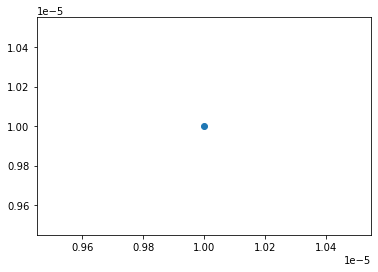

In [13]:
#head positions:
plt.scatter(X['x1'][1], X['y1'][1])


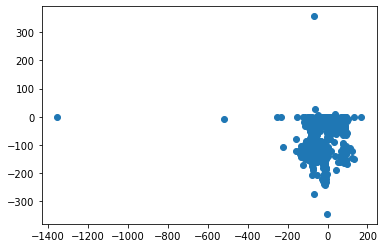

In [14]:
#L_foot_position
plt.scatter(X['x7'], X['y7'])